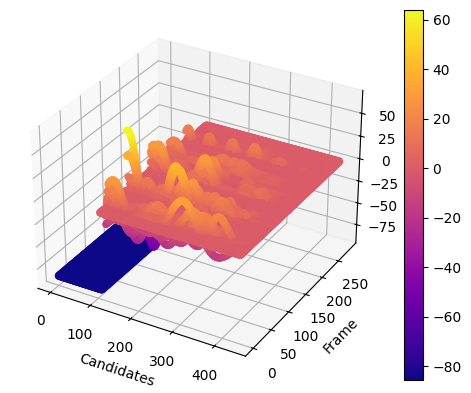

In [3]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# 读取音频文件
filename = "./voice.wav"
sample_rate, sound_array = scipy.io.wavfile.read(filename)
sound_array = sound_array.T[0, :] if sound_array.ndim != 1 else sound_array
sound_array = sound_array / np.max(np.abs(sound_array))  # 归一化

frame_length = int(sample_rate * 0.01)
num_frames = len(sound_array) // frame_length
autocorrelation = np.zeros((num_frames, frame_length))
autocorrelation_of_candidates = np.zeros((num_frames, frame_length))

# 基频阈值为80-400Hz，则基音周期（即延迟）t最小为sample_rate/400，最大为sample_rate/80
min_peak_threshold = min(sample_rate // 400, frame_length)
max_peak_threshold = min(sample_rate // 80, frame_length)
for n in range(num_frames):
    frame = sound_array[n * frame_length: (n + 1) * frame_length]
    autocorrelation[n, :] = scipy.signal.correlate(frame, frame, mode='full')[frame_length - 1:]
# 本应该使用峰值的延迟作为基音周期的候选值，但是发现峰值（局部极大值）并不好判断，同时一帧内的点数不多，因此将阈值内的所有点都作为候选点
# 那么将不在阈值内的自相关系数置为一个非常小的数，从而不让算法选择不在阈值内的基音周期
autocorrelation_of_candidates = autocorrelation
autocorrelation_of_candidates[:, 0:min_peak_threshold] = np.min(autocorrelation) - 10.
autocorrelation_of_candidates[:, max_peak_threshold:] = np.min(autocorrelation) - 10.

x, y = np.meshgrid(np.arange(frame_length), np.arange(num_frames))
x, y, z = x.flatten(), y.flatten(), autocorrelation_of_candidates.flatten()
fig = plt.figure()
ac_3d = fig.add_subplot(111, projection='3d')
sc = ac_3d.scatter(x, y, z, c=z, cmap='plasma')
ac_3d.set_xlabel('Candidates')
ac_3d.set_ylabel('Frame')
ac_3d.set_zlabel('AC Value')
plt.colorbar(sc)
plt.show()

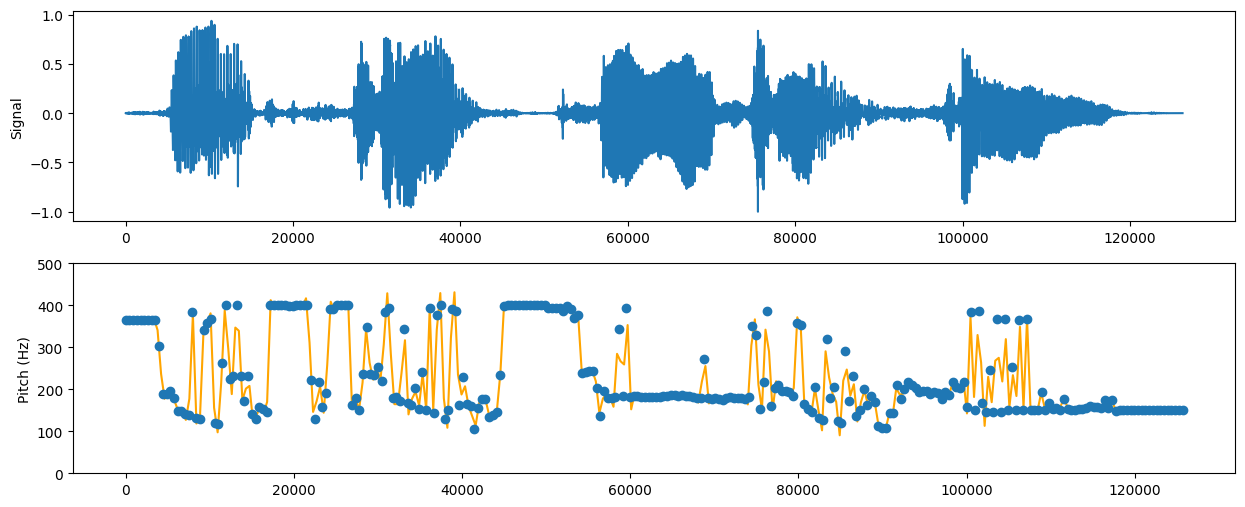

In [11]:
costF = np.zeros((num_frames, frame_length))
path = np.zeros((num_frames, frame_length))
dist = -(autocorrelation_of_candidates - np.min(autocorrelation_of_candidates)) / (np.max(autocorrelation_of_candidates) - np.min(autocorrelation_of_candidates)) * 1e1

costF[0, :] = dist[0, :]

for n in range(num_frames - 1):
    for j in range(min_peak_threshold, max_peak_threshold):
        # f0 = sample_rate / candidate
        costT = np.abs(sample_rate / np.arange(frame_length)[1:] - sample_rate / j)
        costT = (costT - np.min(costT)) / (np.max(costT) - np.min(costT))
        costG = dist[n + 1, j]
        costF[n + 1, j] = costG + np.min(costF[n, 1:] + costT)
        path[n + 1, j] = np.argmin(costF[n, 1:] + costT) + 1

l_hat = np.zeros(num_frames, dtype=np.int32)
l_hat[num_frames - 1] = np.argmin(costF[num_frames - 1, 1:]) + 1

for n in range(num_frames - 2, -1, -1):
    l_hat[n] = path[n + 1, l_hat[n + 1]]

f0 = sample_rate / l_hat

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(sound_array)
plt.ylabel("Signal")
plt.subplot(2, 1, 2)
plt.ylim(0, 500)
x = frame_length * np.arange(num_frames)
y = f0
X_Smooth = np.linspace(x.min(), x.max(), 300)
Y_Smooth = scipy.interpolate.make_interp_spline(x, y)(X_Smooth)
plt.plot(X_Smooth, Y_Smooth, color="orange")
plt.plot(x, y, "o")
plt.ylabel("Pitch (Hz)")
plt.show()